In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)
%matplotlib inline  
plt.style.use('fivethirtyeight')
seed=45

In [24]:
#DOUBTS
#How to decide if credit_history variable is non-numerical?
#Ans:-credit_history is a nominal variable
#How to print multiple graphs in one figure
# is credit_history category or bindary or interval variable?
#Ans:-credit_history is a nominal variable
# is gender, married etc. are careorical or binary variable?
#Ans:-gender, married etc are nominal variables
# is dependents is a oridnal varialble or categorical variable
#Ans:-dependents is nominal variable
# is loan status is binary or categorical variable?
#Ans:-loan_status is nominal variable

#TODOs
#write a loop to print multiple graphs for all numerical variables against all categorical variables 
#to analyze infomration in more detail
# TODO:create plot of loan status of applicants using credit history and gender variable stacked together.i.e 
#You can also add gender into the mix  HOW????
#Write a code to plot the graph to test this -A key hypothesis is that the whether a person is educated or 
#self-employed can combine to give a good estimate of loan amount.

In [25]:
df=pd.read_csv("./input/train.csv")
#test=pd.read_csv("./input/test.csv")
df.head()
#train.tail()
#df.describe() # Get summary of numerical variables
#df.shape
#df.dtypes
#df.info()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [26]:
df.shape

(614, 13)

In [27]:
#Check if there is any class imbalance on target column
target_col='Loan_Status'
df[target_col].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [28]:
#Split data first.
X=df.drop(columns=[target_col])
y=df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
X_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
586,LP002916,Male,Yes,0,Graduate,No,2297,1522.0,104.0,360.0,1.0,Urban
321,LP002053,Male,Yes,3+,Graduate,No,4342,189.0,124.0,360.0,1.0,Semiurban
396,LP002277,Female,No,0,Graduate,No,3180,0.0,71.0,360.0,0.0,Urban
226,LP001754,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban
132,LP001478,Male,No,0,Graduate,No,2718,0.0,70.0,360.0,1.0,Semiurban


In [29]:
# Add target column to X_train for EDA purpose and remove it before model fitting
#X_train[target_col]=y
#X_train.head()
X_train['Dependents'].unique()

array(['0', '3+', nan, '2', '1'], dtype=object)

In [30]:
#Create a meta data table to distinguish levels of data columns
data = []
for f in X_train.columns:
    # Defining the role
    if f == 'Loan_Status':
        role = 'target'
    elif f == 'Loan_ID':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if f == 'Gender' or f == 'Married' or f == 'Education' or f == 'Credit_History' or f == 'Self_Employed' or f == 'Property_Area' or f == 'Loan_Status':
        level = 'nominal' 
    elif df[f].dtype == 'int64' :
        level = 'interval'
    elif df[f].dtype == 'float64' and f != 'Credit_History':
        level = 'ratio'
    elif   f == 'Loan_ID' or f == 'Dependents':
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    #if f == 'Loan_ID':
     #   keep = False
    
    # Defining the data type 
    dtype = X_train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
Loan_ID,id,ordinal,True,object
Gender,input,nominal,True,object
Married,input,nominal,True,object
Dependents,input,ordinal,True,object
Education,input,nominal,True,object
Self_Employed,input,nominal,True,object
ApplicantIncome,input,interval,True,int64
CoapplicantIncome,input,ratio,True,float64
LoanAmount,input,ratio,True,float64


In [31]:
#Check the value counts of nominal variables
nominal_ordinal_cols = meta[(meta.level == 'nominal' ) | (meta.level == 'ordinal') & (meta.keep)].index
for f in nominal_ordinal_cols:
    dist_values = X_train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable Loan_ID has 460 distinct values
Variable Gender has 2 distinct values
Variable Married has 2 distinct values
Variable Dependents has 4 distinct values
Variable Education has 2 distinct values
Variable Self_Employed has 2 distinct values
Variable Credit_History has 2 distinct values
Variable Property_Area has 3 distinct values


In [32]:
nominal_cols = meta[(meta.level == 'nominal' ) & (meta.keep)].index
for f in nominal_cols:
    dist_values = X_train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable Gender has 2 distinct values
Variable Married has 2 distinct values
Variable Education has 2 distinct values
Variable Self_Employed has 2 distinct values
Variable Credit_History has 2 distinct values
Variable Property_Area has 3 distinct values


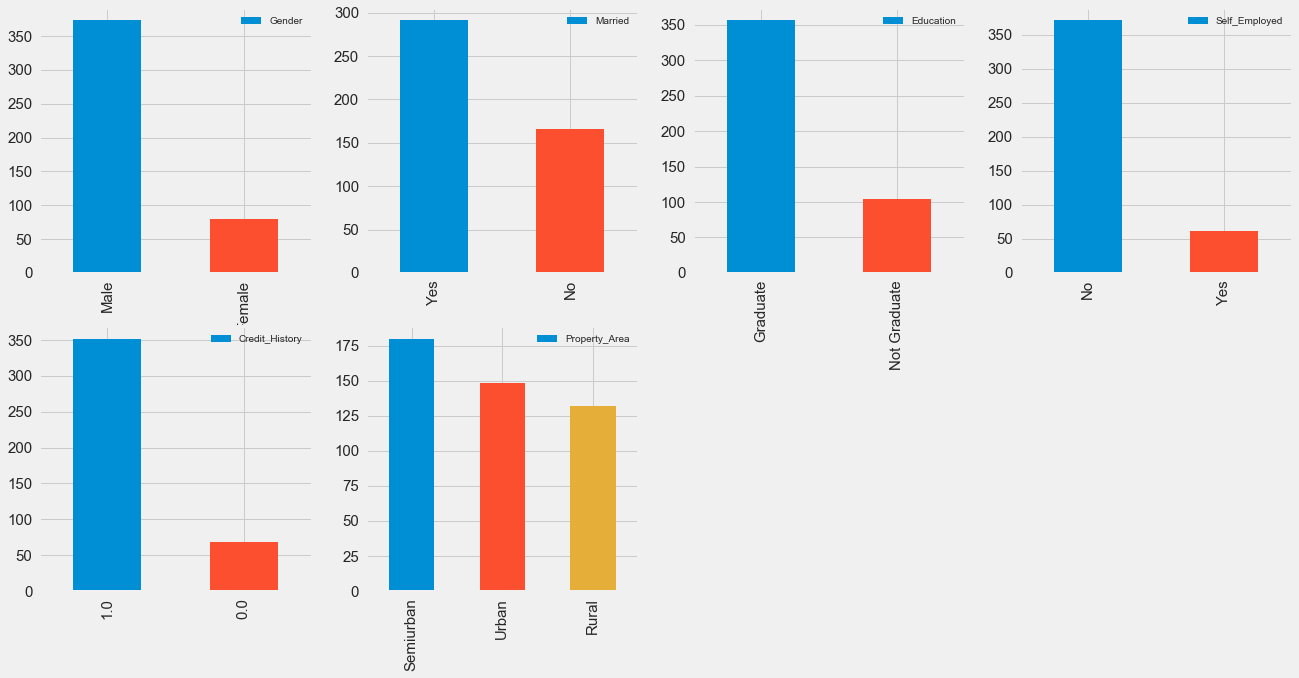

In [33]:
#plot nominal variables
fig = plt.figure()
i=1
for f in nominal_cols:
    axi = fig.add_subplot(2, 4,i)
    X_train[f].value_counts().sort_values(ascending=False).head(20).plot(kind='bar',fontsize=15,legend='true',figsize=(20, 10),ax=axi)
    i=i+1   


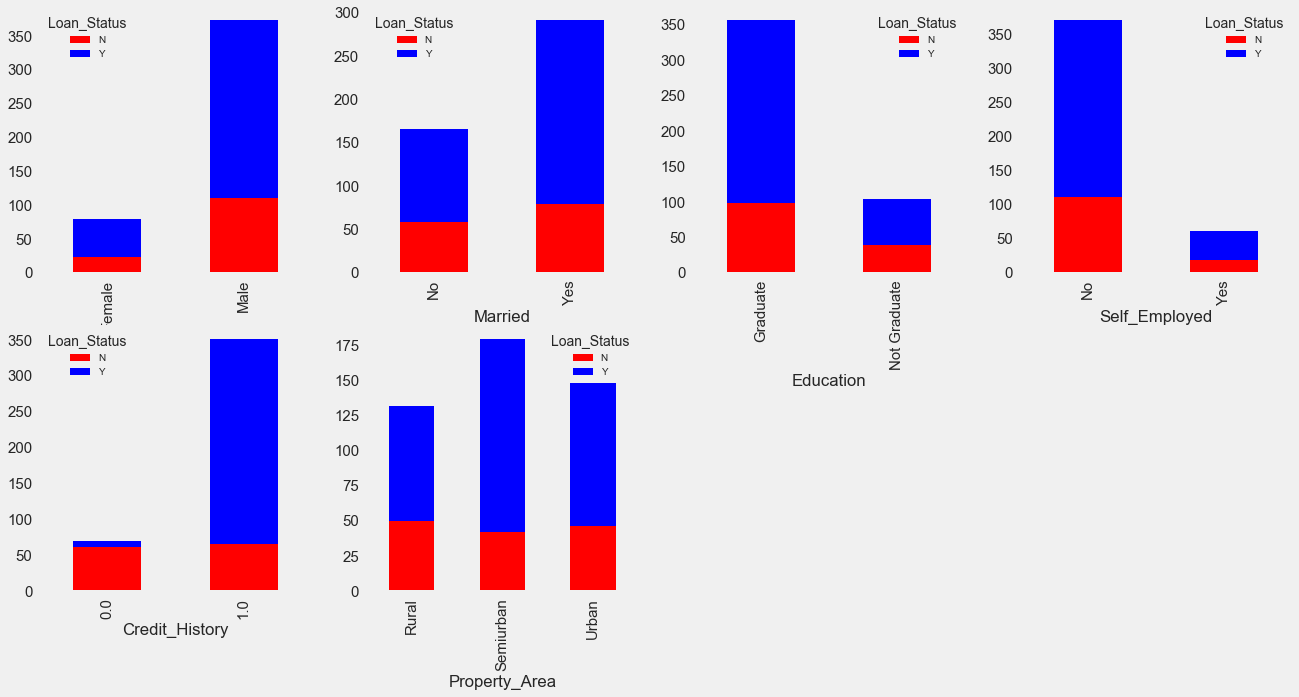

In [34]:
#plot nominal variables with target variable information
#v = meta[(meta.level == 'nominal' ) & (meta.keep)].index
fig = plt.figure()
i=1
for f in nominal_cols:
    if f != 'Loan_Status' :
        axi = fig.add_subplot(2, 4,i)
        temp = pd.crosstab(X_train[f], y_train)
        #df[f].value_counts().sort_values(ascending=False).head(20).plot(kind='bar',fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False,fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        i=i+1



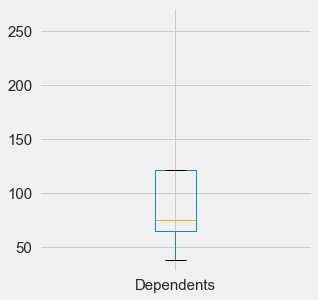

In [35]:
#plot nominal variables with target variable information
ordinal_cols = meta[(meta.level == 'ordinal' ) & (meta.keep)].index
fig = plt.figure()
i=1
for f in ordinal_cols:
    if f != 'Loan_ID' :
        axi = fig.add_subplot(2, 4,i)
        #temp = pd.crosstab(df[f], df['Loan_Status'])
        X_train[f].value_counts().sort_values(ascending=False).plot(kind='box',fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        #temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False,fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        i=i+1

In [36]:
def summarize(data):
    """Create a summary of the input data including min, max,
    mean, median, num obs missing, IQR, etc.
    
    Parameters
    ----------
    data : pd.DataFrame
        The input dataframe to summarize.
    """
    summ = data.describe()
    
    # get the median, name it
    med = data.median()
    med.name = "median"
    
    # append the median row
    summ = summ.append(med, ignore_index=False)
    
    return summ

In [37]:
#Get summary of numerical variables
ratio_interval_cols = meta[( meta.level == 'ratio') | (meta.level == 'interval') & (meta.keep)].index
#df[v].describe()
summarize(X_train[ratio_interval_cols])

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,460.000000,460.000000,443.000000,448.000000
mean,5556.543478,1541.375652,145.568849,341.598214
std,6453.678536,3074.940947,85.517491,64.463501
min,150.000000,0.000000,25.000000,12.000000
25%,2887.250000,0.000000,100.000000,360.000000
50%,3812.500000,1007.000000,126.000000,360.000000
75%,5818.750000,2193.250000,164.500000,360.000000
max,81000.000000,41667.000000,650.000000,480.000000
median,3812.500000,1007.000000,126.000000,360.000000


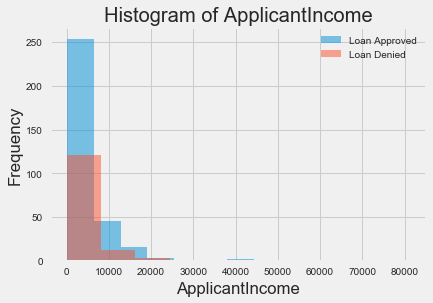

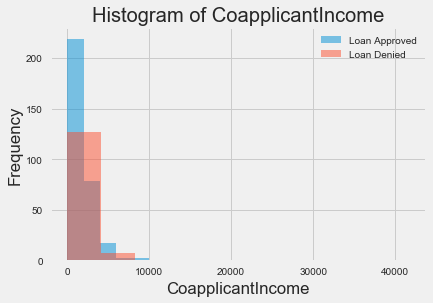

ValueError: max must be larger than min in range parameter.

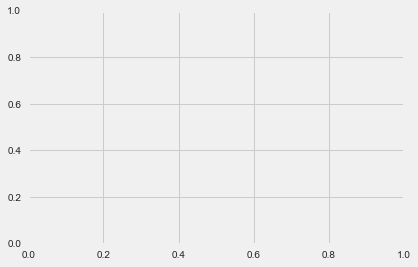

In [38]:
for col in ratio_interval_cols:    
    plt.hist(X_train[y_train=='Y'][col], 10, alpha=0.5, label='Loan Approved')
    plt.hist(X_train[y_train=='N'][col], 10, alpha=0.5, label='Loan Denied')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()

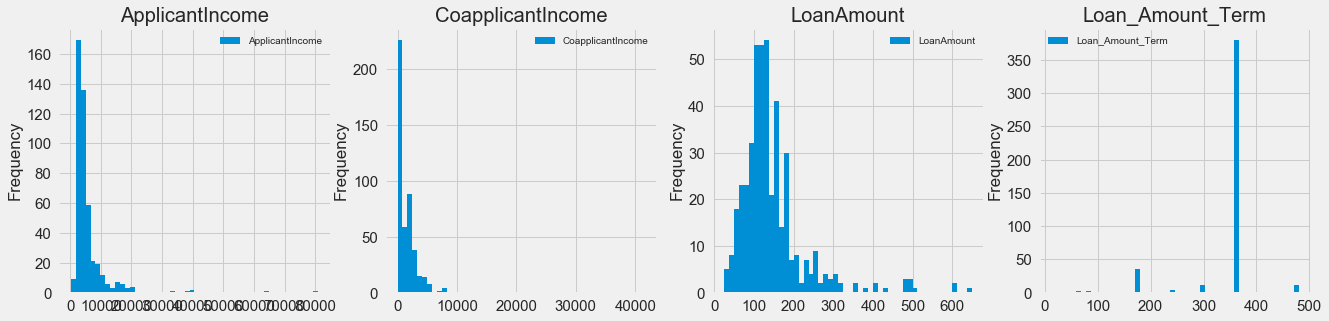

In [39]:
#plot interval variables
#v = meta[(meta.level == 'ratio' ) | (meta.level == 'interval') & (meta.keep)].index
fig = plt.figure()
i=1
for f in ratio_interval_cols:
        axi = fig.add_subplot(2, 4,i)
        #temp = pd.crosstab(df[f], df['Loan_Status'])
        X_train[f].plot(kind='hist',fontsize=15,legend='true',title=f,figsize=(20, 10),ax=axi,bins=50)        
        #temp.plot(kind='hist', stacked=True, color=['red','blue'], grid=False,fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        # axi.hist(temp)
        i=i+1
        


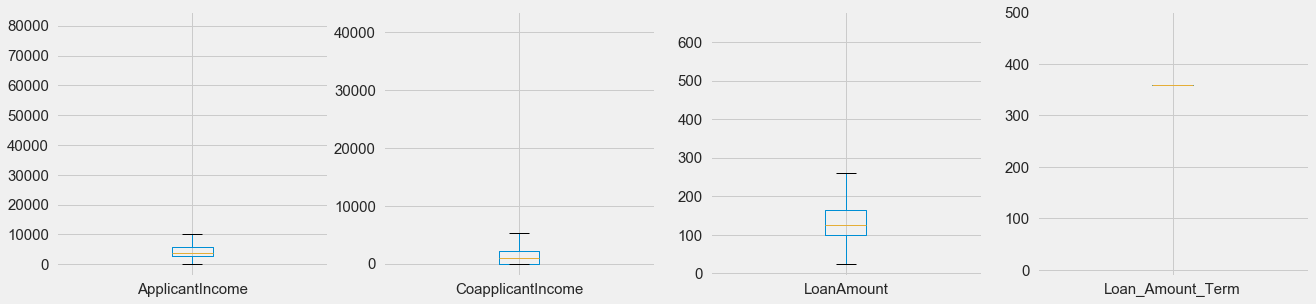

In [40]:
#plot interval variables
#v = meta[(meta.level == 'ratio' ) | (meta.level == 'interval') & (meta.keep)].index
fig = plt.figure()
i=1
for f in ratio_interval_cols:
        axi = fig.add_subplot(2, 4,i)
        #temp = pd.crosstab(df[f], df['Loan_Status'])
        X_train[f].plot(kind='box',fontsize=15,legend='true',figsize=(20, 10),ax=axi)        
        #temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False,fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        i=i+1

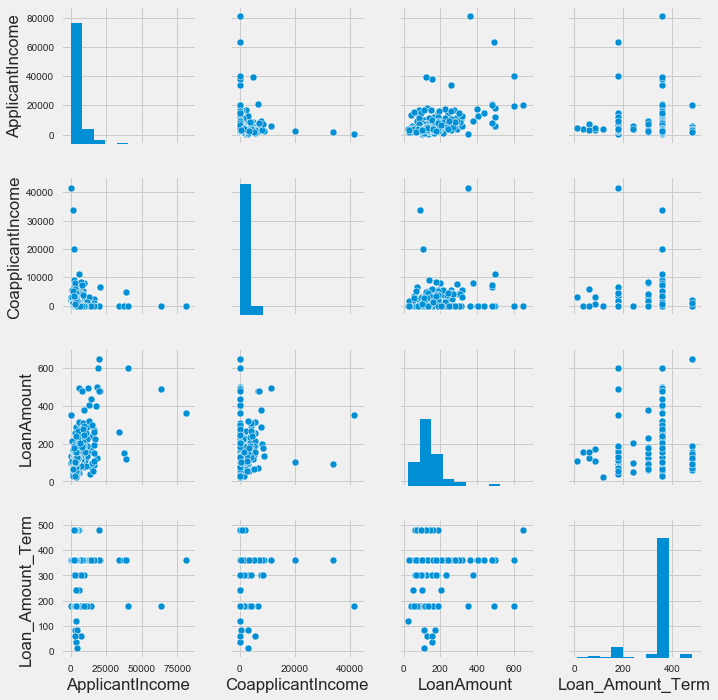

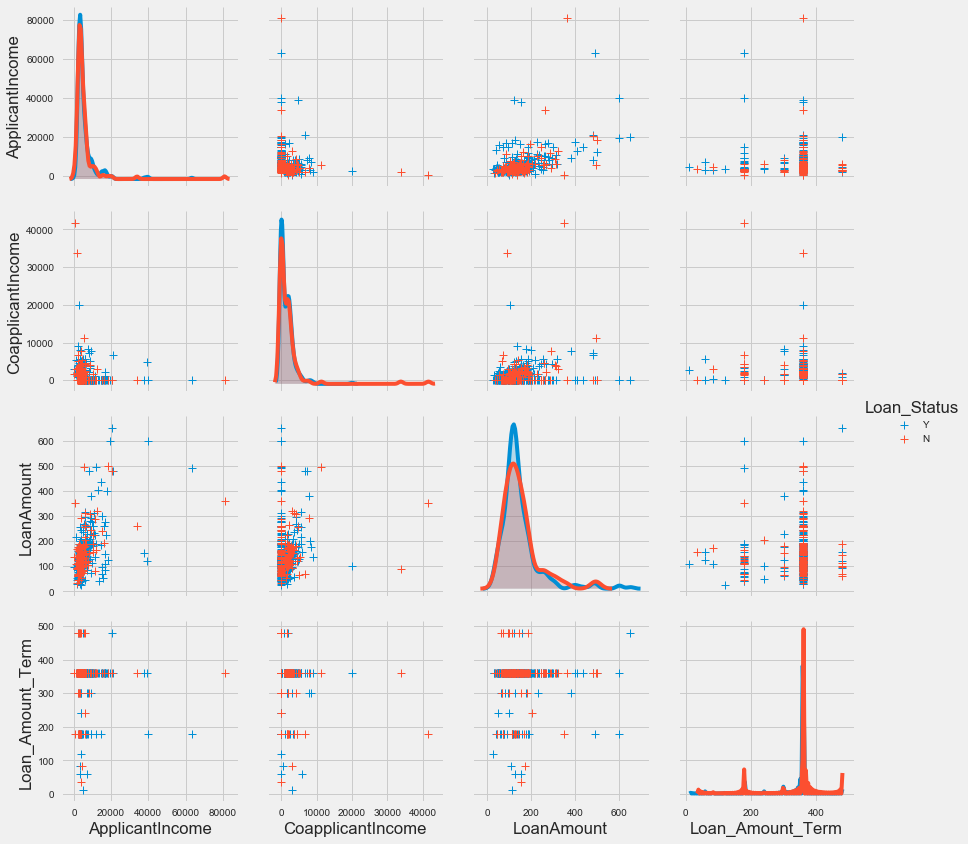

In [41]:
def pairplots(data, target_col_name,plot_type):
    # need to append target
    data = data.copy()  
    data[target_col_name]=y_train
    # get rid of NA to avoid warnings in seaborn
    data = data.dropna()
    if plot_type=='default' :
        sns.pairplot(data)
    else :
         #make a KDE pairplot
             sns.pairplot(data, diag_kind="kde", markers="+",
                            plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                             diag_kws=dict(shade=True), hue=target_col_name,
                            size=3)
pairplots(X_train[ratio_interval_cols], 'Loan_Status','default')
pairplots(X_train[ratio_interval_cols], 'Loan_Status','kde')

In [42]:
corr = X_train[ratio_interval_cols].corr()

# color map (https://stackoverflow.com/questions/39409866/correlation-heatmap)
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
           ]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
ApplicantIncome,1,-0.12,0.52,-0.043
CoapplicantIncome,-0.12,1,0.16,-0.084
LoanAmount,0.52,0.16,1,0.037
Loan_Amount_Term,-0.043,-0.084,0.037,1


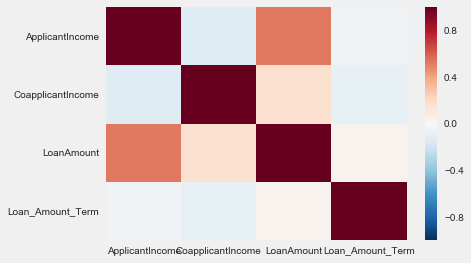

In [43]:
sns.heatmap( X_train[ratio_interval_cols].corr())

In [44]:
#Check for missing values on data
X_train.isnull().sum()


Loan_ID               0
Gender                7
Married               3
Dependents           12
Education             0
Self_Employed        28
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           17
Loan_Amount_Term     12
Credit_History       39
Property_Area         0
dtype: int64

In [65]:
# Custom Imputer to fill empty slots with most common category
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self,cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self
# Lets make an imputer that can apply a strategy to select columns by name

class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self
    
#ordering = ['dislike', 'somewhat like', 'like']  # 0 for dislike, 1 for somewhat like, and 2 for like

#print X['ordinal_column']

#print X['ordinal_column'].map(lambda x: ordering.index(x))
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

class CustomIdRemover(TransformerMixin):
    def __init__(self, col, ):
          self.col = col
        
    def transform(self, df):
        X = df.copy()
        X = X.drop(columns=self.col)
        return X
    
    def fit(self, *_):
        return self
    
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self
    
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class MeanCenter(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
        
    def fit(self, X, y=None):
        self.mean_ = X[self.col].mean()
        return self
    
    def transform(self, X):
        # ensure the transformer has been fit
        check_is_fitted(self, 'mean_')
        
        # always copy the input frame - we don't want to
        # impact the original frame in place
        X = X.copy()
        col = self.col
        X[col] = X[col] - self.mean_
        return X
    
class CustomScaler(TransformerMixin):
    def __init__(self, cols):
         self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        X[self.cols] = X[self.cols].map(lambda x: StandardScaler().fit_transform(x))
        return X
    
    def fit(self, *_):
        return self

In [46]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class CustomPandasTransformer(BaseEstimator, TransformerMixin):
    def _validate_input(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a DataFrame, but got type=%s" 
                            % type(X))
        return X
    
    @staticmethod
    def _validate_columns(X, cols):
        scols = set(X.columns)  # set for O(1) lookup
        if not all(c in scols for c in cols):
            raise ValueError("all columns must be present in X")

class DummyEncoder(CustomPandasTransformer):
    def __init__(self, columns, sep='_', drop_one_level=True, tmp_nan_rep='N/A'):
        self.columns = columns
        self.sep = sep
        self.drop_one_level = drop_one_level
        self.tmp_nan_rep = tmp_nan_rep
        
    def fit(self, X, y=None):
        # validate the input
        X = self._validate_input(X).copy()  # get a copy
        
        # parameter validation happens here:
        tmp_nan = self.tmp_nan_rep
        
        # validate all the columns present
        cols = self.columns
        self._validate_columns(X, cols)
                
        # for each column, fit a label encoder
        lab_encoders = {}
        for col in cols:
            vec = [tmp_nan if pd.isnull(v) 
                   else v for v in X[col].tolist()]
            
            # if the tmp_nan value is not present in vec, make sure it is
            # so the transform won't break down
            svec = list(set(vec))
            if tmp_nan not in svec:
                svec.append(tmp_nan)
            
            le = LabelEncoder()
            lab_encoders[col] = le.fit(svec)
            
            # transform the column, re-assign
            X[col] = le.transform(vec)
            
        # fit a single OHE on the transformed columns - but we need to ensure
        # the N/A tmp_nan vals make it into the OHE or it will break down later.
        # this is a hack - add a row of all transformed nan levels
        ohe_set = X[cols]
        ohe_nan_row = {c: lab_encoders[c].transform([tmp_nan])[0] for c in cols}
        ohe_set = ohe_set.append(ohe_nan_row, ignore_index=True)
        ohe = OneHotEncoder(sparse=False).fit(ohe_set)
        
        # assign fit params
        self.ohe_ = ohe
        self.le_ = lab_encoders
        self.cols_ = cols
        
        return self
    
    def transform(self, X):
        check_is_fitted(self, 'ohe_')
        X = self._validate_input(X).copy()
        
        # fit params that we need
        ohe = self.ohe_
        lenc = self.le_
        cols = self.cols_
        tmp_nan = self.tmp_nan_rep
        sep = self.sep
        drop = self.drop_one_level
        
        # validate the cols and the new X
        self._validate_columns(X, cols)
        col_order = []
        drops = []
        
        for col in cols:
            # get the vec from X, transform its nans if present
            vec = [tmp_nan if pd.isnull(v) 
                   else v for v in X[col].tolist()]
            
            le = lenc[col]
            vec_trans = le.transform(vec)  # str -> int
            X[col] = vec_trans
            
            # get the column names (levels) so we can predict the 
            # order of the output cols
            classes = ["%s%s%s" % (col, sep, clz) for clz in le.classes_.tolist()]
            col_order.extend(classes)
            
            # if we want to drop one, just drop the last
            if drop:
                drops.append(classes[-1])
                
        # now we can get the transformed OHE
        ohe_trans = pd.DataFrame.from_records(data=ohe.transform(X[cols]), 
                                              columns=col_order)
        
        # set the index to be equal to X's for a smooth concat
        ohe_trans.index = X.index
        
        # if we're dropping one level, do so now
        if drops:
            ohe_trans = ohe_trans.drop(drops, axis=1)
        
        # drop the original columns from X
        X = X.drop(cols, axis=1)
        
        # concat the new columns
        X = pd.concat([X, ohe_trans], axis=1)
        return X

In [47]:
a=nominal_cols.tolist()
a.remove('Credit_History')
b=ordinal_cols.tolist()
b.remove('Loan_ID')
b=a+b
print(b)

['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']


In [63]:
cci = CustomCategoryImputer(cols=nominal_ordinal_cols.tolist())
#cci = CustomCategoryImputer(cols=['Dependents'])
#cci.fit_transform(X_train)

cqi = CustomQuantitativeImputer(cols=ratio_interval_cols.tolist(), strategy='mean')

nom_cols=nominal_cols.tolist()
nom_cols.remove('Credit_History')
ord_cols=ordinal_cols.tolist()
ord_cols.remove('Loan_ID')
dummy_cols=nom_cols+ord_cols
cde = DummyEncoder(columns=dummy_cols)

cid=CustomIdRemover(col=['Loan_ID'])

cs=CustomScaler(cols=ratio_interval_cols.tolist())

#cqi.fit_transform(X)
imputer = Pipeline([('quant', cqi), ('scale',cs),('category', cci),('dummy', cde),('cid',cid)])
#imputer = Pipeline([('quant', cqi), ('category', cci)])

# function to build the pipeline
def build_pipe(est, est_name='clf'):
    return Pipeline([
            ('impute', imputer),
            (est_name, est)
        ])

im=imputer.fit_transform(X_train)  # ready for action
im.head()
#im.isnull().sum()
#im['Married'].unique()
#cd = CustomDummifier(cols=['boolean', 'city'])

#cd.fit_transform(X)
#cc = CustomCutter(col='quantitative_column', bins=3)

#cc.fit_transform(X)

#pipe = Pipeline([("imputer", imputer), ('dummify', cd), ('encode', ce), ('cut', cc)])
# will use our initial imputer
# will dummify variables first
# then encode the ordinal column
# then bucket (bin) the quantitative column

AttributeError: 'DataFrame' object has no attribute 'map'

In [49]:
from sklearn.model_selection import KFold

# define our cross validator - remember to shuffle!
cv = KFold(n_splits=3, shuffle=True, random_state=seed)

In [50]:
cv_parts = list(cv.split(X_train))
print("Num splits: %i" % len(cv_parts))
for i, part in enumerate(cv_parts):
    print("Fold %i n_samples: %i" % (i, part[0].shape[0]))

Num splits: 3
Fold 0 n_samples: 306
Fold 1 n_samples: 307
Fold 2 n_samples: 307


In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Fitting a logistic regression with CV
cross_val_score(build_pipe(LogisticRegression(random_state=seed)), 
                X=X_train, y=y_train, cv=cv, scoring='accuracy')

array([ 0.83116883,  0.85620915,  0.78431373])

In [53]:
from sklearn.svm import SVC

# Fitting an SVM
cross_val_score(build_pipe(SVC(random_state=seed)), 
                X=X_train, y=y_train, cv=cv, scoring='accuracy')

array([ 0.7012987 ,  0.7254902 ,  0.67320261])

In [54]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest
cross_val_score(build_pipe(RandomForestClassifier(random_state=seed)), 
                X=X_train, y=y_train, cv=cv, scoring='accuracy')

array([ 0.83116883,  0.76470588,  0.69934641])

In [ ]:
df.boxplot(column='ApplicantIncome', by = 'Education')

In [ ]:
df.boxplot(column='ApplicantIncome', by = 'Gender')

In [ ]:
df['LoanAmount'].hist(bins=50)

In [ ]:
df.boxplot(column='LoanAmount')

In [ ]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print('Frequency Table for Credit History:') 
print (temp1)

print ('\nProbility of getting loan for each Credit History class:') 
print (temp2)




In [ ]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)

ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history")
temp2.plot(kind = 'bar')

In [ ]:
temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

In [ ]:


temp4 = df.pivot_table(values='Loan_Status',index=['Credit_History','Gender'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
#print(temp4)
temp4.plot(kind = 'bar')
temp4 = pd.crosstab(df['Credit_History'], df['Gender'])
temp4.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)


In [ ]:
#find missing values
df.apply(lambda x: sum(x.isnull()),axis=0) 

In [ ]:
df['Dependents'].value_counts()

In [ ]:
df['Loan_Amount_Term'].value_counts()

In [ ]:
df['Credit_History'].value_counts()

In [ ]:
#Impute missing values of non numeric variables :Gender, Married, Dependents, Loan_Amount_Term, Credit_History

df['Gender'].fillna(mode(df['Gender'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Married'].fillna(mode(df['Married'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Self_Employed'].fillna(mode(df['Self_Employed'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Dependents'].fillna(mode(df['Dependents'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Loan_Amount_Term'].fillna(mode(df['Loan_Amount_Term'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Credit_History'].fillna(mode(df['Credit_History'].dropna(axis=0, how='any')).mode[0], inplace=True)

In [ ]:
#Impute missing values of LoanAmount
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [ ]:
df['LoanAmount'].hist(bins=20)

In [ ]:
 df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)

In [ ]:
df['CoapplicantIncome'].hist(bins=20)

In [ ]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
#df['TotalIncome_log'].hist(bins=20) 
df = df.reset_index()

In [ ]:
#Convert categorical data to numeric data
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes 


In [ ]:
df.head()

In [ ]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

In [ ]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area','LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area','LoanAmount','TotalIncome']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#Generally we expect the accuracy to increase on adding variables. But this is a more challenging case. The accuracy and cross-validation score are not getting impacted by less important variables. Credit_History is dominating the mode. We have two options now:
#   Feature Engineering: dereive new information and try to predict those. I will leave this to your creativity.
#    Better modeling techniques. Let’s explore this next.

In [ ]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_log']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#An advantage with Random Forest is that we can make it work with all the features 
#and it returns a feature importance matrix which can be used to select features.
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#Here we see that the accuracy is 100% for the training set. This is the ultimate case of overfitting and can be resolved in two ways:
#    Reducing the number of predictors
#    Tuning the model parameters
#Let’s try both of these. First we see the feature importance matrix from which we’ll take the most important features.

In [ ]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

In [ ]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
''' This exercise gives us some very interesting and unique learning:

#    Using a more sophisticated model does not guarantee better results.
#    Avoid using complex modeling techniques as a black box without understanding the underlying concepts. Doing so would increase the tendency of overfitting thus making your models less interpretable
#    Feature Engineering is the key to success. Everyone can use an Xgboost models but the real art 
     and creativity lies in enhancing your features to better suit the model.
'''